In [13]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np

In [14]:
df = pd.read_csv("../data/acidentes.txt")

In [15]:
df.head()

,data_inversa,fase_dia,horario,uf,br,causa_acidente,tipo_acidente,uso_solo,pessoas,classificacao_acidente,regiao
0,2018-01-01,Pleno dia,06:00:00,TO,BR-153,Falta de Atenção à Condução,Colisão frontal,Rural,2,Com Vítimas Feridas,Norte
1,2018-01-01,Pleno dia,08:30:00,SE,BR-101,Não guardar distância de segurança,Colisão traseira,Rural,2,Sem Vítimas,Nordeste
2,2018-01-01,Pleno dia,08:50:00,TO,BR-153,Falta de Atenção à Condução,Colisão lateral,Rural,3,NaN,Norte
3,2018-01-01,Amanhecer,05:30:00,PA,BR-155,Ingestão de Álcool,Colisão lateral,Rural,2,Com Vítimas Fatais,Norte
4,2018-01-01,Pleno dia,10:25:00,BA,BR-116,Ultrapassagem Indevida,Saída de leito carroçável,Rural,2,Com Vítimas Feridas,Nordeste


In [16]:
df = df[df['classificacao_acidente'].notna()].copy()

X = df.drop(columns=['classificacao_acidente'])
y = df['classificacao_acidente']

### **XGboost**

Escolhemos o XGBoost, pois é um dos algoritmos mais eficientes para classificação, utilizando paralelismo e otimização de recursos. Além disso, ele é muito eficiente para lidar com dados desbalanceados, encontrando padrões e relações entre as variáveis, possibilitando uma melhor performance do modelo.

In [17]:
df['classificacao_acidente'].unique()

array(['Com Vítimas Feridas', 'Sem Vítimas', 'Com Vítimas Fatais'],
      dtype=object)

In [18]:
categorical_features = X.select_dtypes(include="object").columns
numerical_features = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

O label_encoder é utilizado para transformar as classes categóricas da variável alvo (y) em valores numéricos.
Isso é necessário porque muitos algoritmos de machine learning, incluindo o XGBoost, exigem que os rótulos estejam em formato numérico para realizar a classificação.

In [19]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(np.unique(y_encoded))
print(label_encoder.classes_)

[0 1 2]
['Com Vítimas Fatais' 'Com Vítimas Feridas' 'Sem Vítimas']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [21]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softmax',
        eval_metric='mlogloss'
    ))
])

In [22]:
param_grid = {
    'classifier__n_estimators': [200, 500, 700, 1000],
    'classifier__max_depth': [3, 6, 9, 12],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
}

In [23]:
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=50, cv=5, 
                                       verbose=1, n_jobs=4, scoring='accuracy', random_state=13)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\DellGamer\projetos\A3-USJT-Global-Cybersecurity-Threats\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'classifier__colsample_bytree': [0.8, 0.9, ...], 'classifier__max_depth': [3, 6, ...], 'classifier__n_estimators': [200, 500, ...]}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,4
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,13
,error_score,nan


In [24]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix
)

y_pred = randomized_search.predict(X_test)
y_proba = randomized_search.predict_proba(X_test)

print(len(label_encoder.classes_))
labels = np.arange(len(label_encoder.classes_))
print(label_encoder.classes_)


print(confusion_matrix(y_test, y_pred, labels=labels))

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão (macro):", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro', zero_division=0))

3
['Com Vítimas Fatais' 'Com Vítimas Feridas' 'Sem Vítimas']
[[  93  800   18]
 [  83 9557  333]
 [   9 2325  649]]
Acurácia: 0.7426984928246917
Precisão (macro): 0.6350968216284413
Recall (macro): 0.42597973487582447
F1-score (macro): 0.4464306677321624


### **Modelo de Random Florest**

In [28]:
X_train.columns

Index(['data_inversa', 'fase_dia', 'horario', 'uf', 'br', 'causa_acidente',
       'tipo_acidente', 'uso_solo', 'pessoas', 'regiao'],
      dtype='object')

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)) 
])

In [34]:
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [35]:
rf_randomized_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=rf_param_grid, 
    n_iter=50, 
    cv=5, 
    verbose=1, 
    n_jobs=4, 
    scoring='accuracy', 
    random_state=13
)

In [36]:
rf_randomized_search.fit(X_train, y_train) 
y_pred_rf = rf_randomized_search.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [45]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Modelo Random Forest: {accuracy:.4f}")
print("\n--- Relatório de Classificação ---\n")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Acurácia do Modelo Random Forest: 0.7345

--- Relatório de Classificação ---

                     precision    recall  f1-score   support

 Com Vítimas Fatais       0.75      0.00      0.01       911
Com Vítimas Feridas       0.73      1.00      0.84      9973
        Sem Vítimas       0.95      0.07      0.14      2983

           accuracy                           0.73     13867
          macro avg       0.81      0.36      0.33     13867
       weighted avg       0.78      0.73      0.64     13867



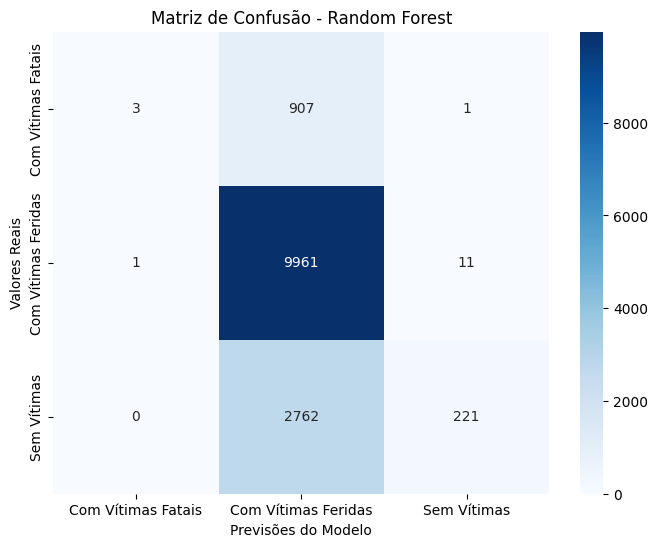

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Valores Reais')
plt.xlabel('Previsões do Modelo')
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

svc_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 0.1]
}

svc_grid_search = GridSearchCV(
    svc_pipeline,
    param_grid=svc_param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

svc_grid_search.fit(X_train, y_train)
y_pred_svc = svc_grid_search.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Modelo Random Forest: {accuracy:.4f}")
print("\n--- Relatório de Classificação ---\n")

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))